In [1]:
%load_ext lab_black

import os
import re
import pandas as pd

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from tqdm import tqdm_notebook


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv("../data/seriouseats/seriouseats.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8312 entries, 0 to 8311
Data columns (total 11 columns):
title                8312 non-null object
short_description    2114 non-null object
thumbnail            8312 non-null object
url                  8312 non-null object
description          7787 non-null object
directions           8282 non-null object
ingredients          8282 non-null object
rating               2898 non-null float64
total_time           5810 non-null object
active_time          6119 non-null object
yields               7518 non-null object
dtypes: float64(1), object(10)
memory usage: 714.4+ KB


In [4]:
def delete_preamble(title):
    if ":" in title:
        title_split = title.split(":")
        return title_split[-1].strip()
    return title


def get_title_post_description(title):
    match = re.search(r".+\((.+)(\)|\.{3})", title)
    if match:
        return match.group(1)
    return title


def remove_the_best_prefix(title):
    match = re.search(r"The Best (.+)", title)
    if match:
        return match.group(1)
    return title


df["title"] = df["title"].map(delete_preamble)
df["title"] = df["title"].map(get_title_post_description)
df["title"] = df["title"].map(remove_the_best_prefix)
df["image_path"] = df["thumbnail"].apply(
    lambda x: os.path.join("../data/seriouseats/images", x.rsplit("/", 1)[-1])
)
df = df[df["image_path"].apply(lambda x: os.path.isfile(x))]

In [85]:
df.head()

,title,short_description,thumbnail,url,description,directions,ingredients,rating,total_time,active_time,yields,image_path,high_freq_labels
0,Jammy Fruit Bars,"Simple but satisfying fruit bars, made with your favorite fresh fruit or jam.",https://www.seriouseats.com/2019/05/20190429-fruit-oat-bars-vicky-wasik-20-625x469.jpg,https://www.seriouseats.com/recipes/2019/05/jammy-fruit-bars.html,"These fruity, oaty bars are inspired by Icelandic Hjónabandssæla (often translated as ""happy marriage cake""), but perhaps closer to an American bar cookie in execution. They're hearty and rich, thanks to plenty of rolled oats and butter in the crust and crumb topping, with a flavorful layer of jam or fresh fruit in between. What kind? That's all up to you!","Getting Ready: Adjust oven rack to lower-middle position and preheat to 350°F (180°C). Line an 8- by 2-inch square, anodized aluminum pan with two long strips of parchment to cover the bottom and sides, creasing as needed to ensure a secure fit.||||Make the Dough: In a large bowl, combine the rolled oats, all-purpose flour, brown sugar, baking powder, salt, baking soda, and cinnamon, then mix until homogenous. If needed, this dry mix can be bagged and stored at cool room temperature up until the date stamped on the carton of oatmeal. Add the butter, toss to break up the pieces, and smash each cube flat. Continue smashing and rubbing until the butter has mostly disappeared into a clumpy, streusel-like mix. This can also be done on low speed in the bowl of a stand mixer fitted with a paddle attachment, but take care not to overdo it. Add the egg and stir with a flexible spatula until well incorporated to form a soft dough.||||Making the Bars: Scatter 16 ounces (about two-thirds of the mixture; 455g) into the bottom of the prepared cake pan, and gently press into an even layer. The idea is to encourage the pieces into a single sheet, without compressing the dough with excessive force.\r\n||||Spread the jam or scatter the fruit into an even layer over the dough. Sprinkle with salt and a squeeze of fresh lemon juice, to bring balance to the fruit or jam. The amount needed will vary for both, depending on the type of fruit and its sweetness/acidity, with sweeter, milder fruits or jams requiring a bit of a heavy hand, and mellow, acidic fruits needing less. That said, virtually all fruits and jams will benefit from at least a small sprinkling of salt and squeeze of lemon, so don't skip this step altogether.||||Sprinkle the remaining dough on top of the jam or fruit layer, crumbling it like streusel. Bake until the ""cake"" is puffed, firm, and golden brown, about 45 minutes, although the exact timing will vary depending on the moisture content of the jam or fruit.||||Cool directly in the pan until the bars are room temperature, then loosen the two exposed sides from the pan with a dull knife. Gently tug at the parchment to loosen the bars, then transfer to a cutting board, and cut into pieces as desired. Serve with a dollop of whipped cream, or plain as a bar cookie. Wrapped tightly in plastic, the bar cookies will keep three or four days at cool room temperature.","For the Dough:||||4 1/2 ounces old fashioned rolled oats, not quick cooking, instant, or thick cut (about 1 1/3 cup; 128g)||||4 1/2 ounces all-purpose flour (about 1 cup, spooned; 128g)||||6 ounces light brown sugar (about 3/4 cup, firmly packed; 170g)||||1 teaspoon baking powder||||1 teaspoon (4g) Diamond Crystal kosher salt, plus more for sprinkling; for table salt, use about half as much by volume or the same weight, plus additional salt for sprinkling||||1/4 teaspoon baking soda||||1/4 teaspoon ground cinnamon||||6 ounces cold, unsalted butter, cut into 1/2-inch cubes (about 3/4 cup; 170g)||||1 large egg, straight from the fridge (about 1 3/4 ounces; 50g)||||For the Filling:||||8 ounces jam (volume will vary; 225g) or 12 ounces ""juicy"" fruit, such as whole blueberries or raspberries, pitted cherries, sliced strawberries, or p

In [6]:
df[df["title"].apply(lambda x: "burger" in x.lower())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 77 to 8247
Data columns (total 12 columns):
title                121 non-null object
short_description    48 non-null object
thumbnail            121 non-null object
url                  121 non-null object
description          112 non-null object
directions           120 non-null object
ingredients          121 non-null object
rating               49 non-null float64
total_time           75 non-null object
active_time          84 non-null object
yields               116 non-null object
image_path           121 non-null object
dtypes: float64(1), object(11)
memory usage: 12.3+ KB


In [7]:
import nltk

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/mike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/mike/.local/share/virtualenvs/seefood-qNVnXCKQ/lib/python3.7/site-packages/en_core_web_sm
-->
/home/mike/.local/share/virtualenvs/seefood-qNVnXCKQ/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [9]:
import gensim
from gensim import corpora
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("en", disable=["parser", "ner"])
stop_words = stopwords.words("english")
stop_words.extend(
    [
        "from",
        "subject",
        "re",
        "edu",
        "use",
        "like",
        "recipe",
        "cook",
        "dish",
        "easy",
        "simple",
        "homemade",
        "style",
        "gluten",
        "free",
        "sweet",
        "cookbook",
        "fresh",
        "quick",
    ]
)

In [10]:
title_words = df["title"].apply(lambda x: gensim.utils.simple_preprocess(x, deacc=True))
description_words = df["description"].apply(
    lambda x: gensim.utils.simple_preprocess(str(x), deacc=True)
)

title_bigram = gensim.models.Phrases(title_words, min_count=10, threshold=100)
title_trigram = gensim.models.Phrases(title_bigram[title_words], threshold=100)
title_bigram_mod = gensim.models.phrases.Phraser(title_bigram)
title_trigram_mod = gensim.models.phrases.Phraser(title_trigram)

description_bigram = gensim.models.Phrases(
    description_words, min_count=4, threshold=100
)
description_trigram = gensim.models.Phrases(
    description_bigram[description_words], threshold=100
)
description_bigram_mod = gensim.models.phrases.Phraser(description_bigram)
description_trigram_mod = gensim.models.phrases.Phraser(description_trigram)


def remove_stopwords(titles):
    return [
        [w for w in gensim.utils.simple_preprocess(str(title)) if w not in stop_words]
        for title in titles
    ]


def make_bigrams(titles, bigram_mod):
    return [bigram_mod[t] for t in titles]


def make_trigrams(titles, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[t]] for t in titles]


def lemmatization(titles):
    titles_out = []
    for sent in titles:
        doc = nlp(" ".join(sent))
        titles_out.append([token.lemma_ for token in doc])
    return titles_out

In [11]:
import itertools

title_words_nostops = remove_stopwords(title_words)
title_words_bigrams = make_bigrams(title_words_nostops, title_bigram_mod)
title_words_trigrams = make_trigrams(
    title_words_bigrams, title_bigram_mod, title_trigram_mod
)
title_words_lemmatized = lemmatization(title_words_trigrams)

description_words_nostops = remove_stopwords(description_words)
description_words_bigrams = make_bigrams(
    description_words_nostops, description_bigram_mod
)
description_words_trigrams = make_trigrams(
    description_words_bigrams, description_bigram_mod, description_trigram_mod
)
description_words_lemmatized = lemmatization(description_words_trigrams)

# if words appear in titles as well, we consider them as relevant
def find_relevant_words(descriptions):
    title_d = corpora.Dictionary(title_words_lemmatized)
    title_words_vocab = [
        t
        for t in set(itertools.chain(*title_words_lemmatized))
        if title_d.dfs[title_d.token2id[t]] > 60
    ]

    result = []
    for d in descriptions:
        result.append([t for t in d if t in title_words_vocab])
    return result


description_words_filtered = find_relevant_words(description_words_lemmatized)


words = [set(t + d) for t, d in zip(title_words_lemmatized, description_words_filtered)]

In [12]:
d = corpora.Dictionary(words)
word_frequency = {token: d.dfs[d.token2id[token]] for token in d.token2id.keys()}
wf_df = pd.DataFrame.from_dict(word_frequency, orient="index").reset_index()
wf_df.columns = ["word", "frequency"]
wf_df = wf_df.sort_values(by=["frequency"], axis=0, ascending=False).reset_index(
    drop=True
)
wf_df.head()
wf_df[:500].describe()
wf_df[:500].head()

,word,frequency
0,sauce,1839
1,chicken,1191
2,cheese,1075
3,salad,951
4,garlic,881


,frequency
count,500.00000
mean,109.01400
std,203.52706
min,12.00000
25%,17.00000
50%,28.00000
75%,57.00000
max,1839.00000


,word,frequency
0,sauce,1839
1,chicken,1191
2,cheese,1075
3,salad,951
4,garlic,881


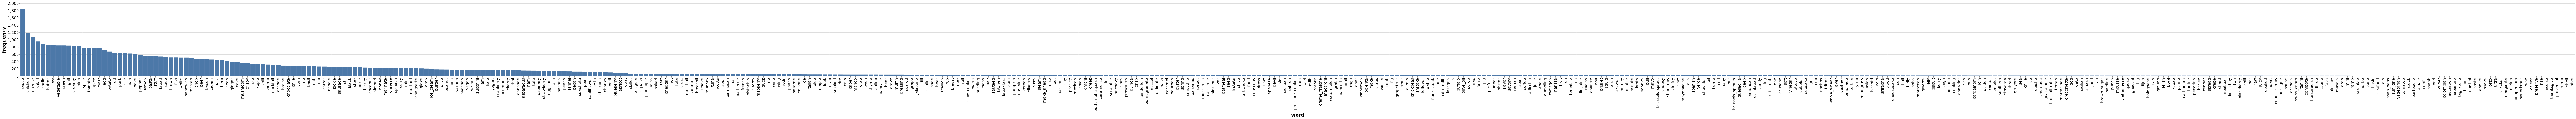

In [13]:
import altair as alt

alt.Chart(wf_df[:500]).mark_bar().encode(
    x=alt.X("word", sort=alt.EncodingSortField(field="frequency", order="ascending")),
    y="frequency",
).configure_axis(labelFontSize=16, titleFontSize=19)

In [14]:
data_lemmatized_high_freq_only = [
    [t for t in sent if d.dfs[d.token2id[t]] > 10] for sent in words
]
df["high_freq_labels"] = [set(sent) for sent in data_lemmatized_high_freq_only]

In [15]:
pd.set_option("max_colwidth", -1)
df_no_label = df[df["high_freq_labels"].apply(lambda x: len(x) == 0)][
    ["title", "description"]
].dropna()
df_no_label.shape
df_no_label

(31, 2)

,title,description
79,Foie Gras Torchon,"Note: It is possible to make this recipe using imperial measures, but I strongly recommend using metric, as it makes figuring out how much seasoning mix to use very simple. This recipe will make more seasoning mix than you need for one batch. I recommend La Belle Farms foie gras, which is available online from Bella Bella Gourmet."
225,Easy Cioppino,"Mussels can be substituted for the cockles, but if you use clams, then put them in a few minutes before the other seafood as they usually take a couple minutes longer to cook."
288,Don's Mix,"An essential ingredient in many tiki drinks, this is an extremely simple recipe that will be tastiest with fresh grapefruits in season. Feel free to experiment with Demerara sugar for more flavor."
345,Homemade Bagel Bites,"If you can't understand the allure of made-from-scratch Bagel Bites, there's nothing I can say or do to convince you. This is a recipe for the hardcore fans, those of us who've longed for bite-size pizza poppers that taste as good as we remember—chewy, cheesy, salty, and crisp."
359,Shandy,"A radler is the German word for what is sometimes known as a shandy: a mix of light, cold beer and sparkling lemonade (or, in this case, Grapefruit-ade). You can buy a premixed grapefruit radler but it lacks the pop of juicy flavor you get from this fresh version. Here, the grapefruit soda is made not just with the juice but also the citrus oils from the citrus skin; a dose of lemon juice ensures it's tart enough."
426,A Decadent Eggnog From a Junior League Cookbook,"Eggnog may be second only to fruitcake as a holiday punchline. And why not? It comes up most often as an explanation for otherwise inexplicable behavior at office parties, and the pre-made version in most grocery stores resembles an opaque, insipid quart of 10W-30 motor oil. For the first 30 or so years of my life, I never gave much eggnog much thought. Then, thanks to a lucky day at Myopic Books, the Gourmet's Guide to New Orleans came into my life. The name is misleadingit is, in fact, a Junior League cookbook. Charleston Receipts is probably the most famous Junior League cookbook, but as a rule, they are worth keeping an eye out for when you trawl the cookbook section at your favorite used book store. My copy is the 13th edition, from 1955, but I don't know when the eggnog recipe became part of the collection. After I read the recipe, I knew immediately I had to make it:\nYou'll notice a complete absence of any redeeming ingredient. There is a perverse genius in presenting this concoction as something that adults might make and serve to one another. So I made it. It became a holiday party staple. Nobody asks for it at Labor Day, but about once a year, it has its place. As you approach the end of the gauntlet of holiday parties, I urge you to make this recipe. I would offer a few notes on Mrs. Steven Pierre Cottreaux' recipe:"
1274,Algonquin,"As much as I like to imagine it happening, chances are that Dorothy Parker, Alexander Woolcott and the rest of the gang never tipped up a round of these.While the members of the Algonquin Round Table likely never got on the outside of an Algonquin—the drink's recipe didn't appear in print until years after the legendary lunch meetings ended—this mixture bearing the name of that venerable hotel is as dry and captivating as was their wit. Fortunately, while the Round Table disbanded around 1929, it's not too late to explore the flavor of the Algonquin."
1350,Graisserons,Adapted from The Zuni Cafe Cookbook by Judi Rodgers.
1405,Mindy's Recipe for Romance,"For the story behind this fondue, read ""Murray's Fondue and the City""»"
1846,PBJ,"I must confess that I don't like peanut butter, nor its classic incarnation in a PBJ. It sticks to your mouth! Why would I want something to stick to the roof of my mouth like that? Yes, there's milk, but I don't want to be forced to drink milk like that. It's just not right. Anyway, don't let my slight revulsio

In [16]:
df["image_path"] = df["thumbnail"].apply(
    lambda x: os.path.join("../data/seriouseats/images", x.rsplit("/", 1)[-1])
)

df = df[df["image_path"].apply(lambda x: os.path.isfile(x))]

import glob
import random
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML

pd.set_option("display.max_colwidth", -1)


def get_thumbnail(path):
    i = Image.open(path).convert("RGB")
    i.thumbnail((224, 224), Image.LANCZOS)
    return i


def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, "jpeg")
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

,title,high_freq_labels,image_path
1332,Peanut Butter Butter Sweet Rolls,"{roll, butter, glaze, chocolate, peanut}",
4532,"Easy Pan Pizza With Sun-dried Tomatoes, Caramelized Onions, Olives, and ...","{pizza, onion, sun_drie, caramelize, pan, tomato, olive}",
1821,Raspberry Double-Crust Jar Pie,"{pie, brown, double, crust, raspberry}",
782,Aleppo-Rubbed Pork Ribs,"{pepper, rib, rub, pork, spice}",
372,Sous Vide Barbecue Pulled Pork Shoulder,"{pull, shoulder, sous_vide, barbecue, pork}",
8265,Buldak,"{sauce, chicken, marinate, spicy, cheese}",
4421,"Pasta with Asparagus, Lemon and Pine Nuts","{asparagus, fennel, lemon, pasta, pine_nut}",
7511,Easy Fresh Mexican Chorizo,"{sausage, taco, mexican, chorizo}",
308,Tacos de Lengua,"{de, lamb, beef, pork, taco}",
1645,The Easiest Chocolate Peanut Butter Mousse Pie,"{pie, butter, chocolate, mousse, peanut}",

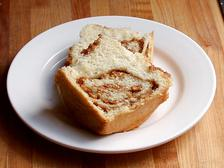
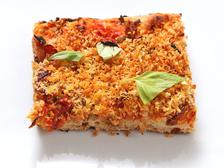
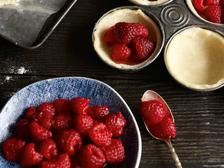
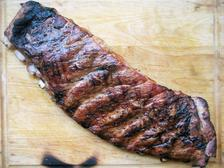
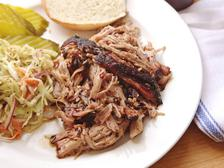
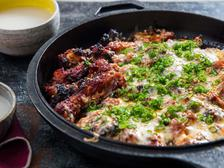
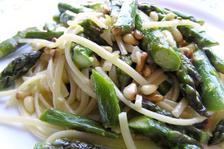
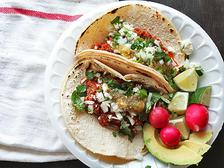
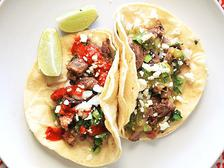
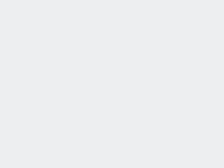
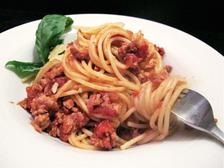
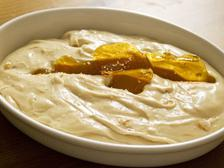
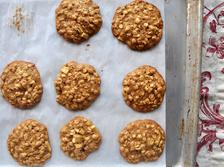
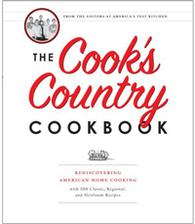
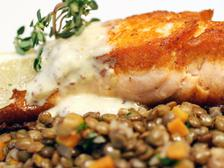
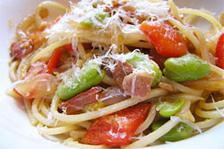
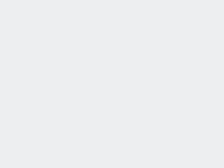
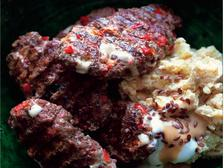
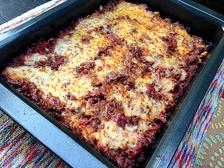
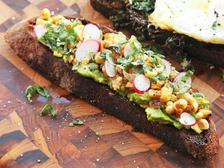

In [28]:
df_sample = df[["title", "high_freq_labels", "image_path"]].sample(20)

HTML(df_sample.to_html(formatters={**{"image_path": image_formatter}}, escape=False))

In [24]:
labels = set(itertools.chain(*df["high_freq_labels"].tolist()))
print(f"Number of labels: {len(labels)}")

Number of labels: 537


In [34]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


image_model = models.squeezenet1_0(pretrained=True)
set_parameter_requires_grad(
    image_model, True
)  # make sure we only modify the last layer


class ImageFeatureExtractor(nn.Module):
    def __init__(self, image_model):
        super(ImageFeatureExtractor, self).__init__()
        self.image_model = image_model.features
        self.avg_pool2d = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.image_model(x)
        x = self.avg_pool2d(x)
        x = x.reshape(-1, 512)
        return x


feature_extractor = ImageFeatureExtractor(image_model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

In [53]:
IMAGE_SIZE = 224


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.images = df["image_path"].reset_index(drop=True)
        self.transform = transforms.Compose(
            [
                transforms.Resize(IMAGE_SIZE),
                transforms.CenterCrop(IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image


dataset = ImageDataset(df)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=False, num_workers=2
)

In [54]:
features = []
for item in dataloader:
    item = item.to(device)
    features.append(feature_extractor(item))

features = torch.cat(features)
features.size()

/home/mike/.local/share/virtualenvs/seefood-qNVnXCKQ/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8552 bytes but only got 8356. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag))


torch.Size([8304, 512])

In [55]:
from annoy import AnnoyIndex

annoy_index = AnnoyIndex(512)
if os.path.isfile("index_baseline_model_pytorch.ann"):
    annoy_index.load("index_baseline_model_pytorch.ann")
else:
    for i, f in enumerate(features):
        annoy_index.add_item(i, f)

    annoy_index.build(10000)
    annoy_index.save("index_baseline_model_pytorch.ann")

True

True

,image_path,n_0,n_1,n_2,n_3,n_4,n_5,n_6
0,,"{pizza, tomato, meatball, sauce}","{coconut, cream}",{},"{onion, gratin, new, cheesy, bacon, potato, cheese}","{stew, vegetable, onion, sauce, chop, beef, pasta, garlic, tomato, cheese}","{sauce, roll, stuff, bake, tomato, cabbage, bacon, rice, smoky}","{quiche, meat, potato}"
1,,"{onion, sauce, pepper, chili, pasta, sausage, egg, tomato, red, bacon, spaghetti, spice, cheese}","{summer, tomato, pasta}","{pasta, tomato, crab, zucchini, linguine}","{coleslaw, vinaigrette, creamy, chili}","{peruvian, salad, seafood, onion, fry, red, tomato, lime, fish, marinate, spicy, shrimp}","{ginger, chicken, shred, stuff, curry, noodle, red, pork, rice, spicy}","{orzo, chard, dill, baked, feta}"
2,,"{pecorino, italian, grill, meatball, beef, egg, garlic, parmesan, pork, cheese}","{rum, oat, bake, baked, crumble, jam, apple}","{salad, ginger, herb, rice, burger, patty, cilantro, chili, garlic, white, lime, pork, bacon, thai, spice}","{sauce, brown, patty, egg, indian, rice, spicy}","{yogurt, muffin, berry, crumble, brown_sugar}","{pie, sauce, butter, pea, stuff, brown, crust, bake, meatloaf, parmesan, carrot, potato, cheese}","{yogurt, sauce, lamb, meatball, beef, garlic, tomato, walnut, bread, spaghetti, spice}"
3,,"{ginger, wrap, stuff, spinach, sandwich, shrimp}",{corn},"{noodle, skin, tofu}","{layer, cake, lemon}","{cookie, butter, egg, bake, bread, white, almond}","{vegetable, asparagus, savory, bean, spinach, green, broth, japanese}","{sauce, bean, avocado, brown, rice, creamy, spice, cheese}"
4,,"{french, sauce, turkey, roast, sandwich, soup, bake, baked, bread, cranberry, toast}","{onion, bean, sandwich, bread, pork, spicy, pickle, cheese}","{sous_vide, rib, barbecue, pork}","{onion, avocado, stuff, sandwich, green, lime, chile, crab, creamy}","{onion, bread, whole_wheat}","{grill, sandwich, chorizo, creamy, spicy, toast, cheese}","{salad, butter, fry, grill, sandwich, pan, egg, green, vinaigrette, bread, white, toast, cheese}"
5,,"{sauce, rib, pork, spicy, bourbon}","{ginger, fennel, red, spice, marinate, chinese}","{onion, sauce, rib, roast, chipotle, garlic, black, oven}","{pineapple, honey, garlic, tomato, glaze, braise, apple}","{coconut, cream}","{grill, thai, pork}","{sauce, wing, egg, bake, thai, crispy, spicy}"
6,,"{butter, steak, sear, grill, pan}","{sous_vide, rib, barbecue, pork}","{herb, butter, steak, grill, chipotle, garlic, lime, rub, spicy, spice}","{chicken, cabbage, bacon, thigh, crispy, braise}","{asparagus, vegetable, spinach, ham, frittata, creamy, cheese}","{brown, stuffing, turkey, stuff}","{marinate, sardine}"
7,,{cocktail},"{banana, honey, cocktail, egg, almond, spice, roasted}","{cobbler, cranberry}","{stew, salt, lemon, preserve}","{cocktail, basil}","{ice_cream, sauce, apricot, peach, cake, toast}","{diy, raspberry}"
8,,"{salad, sauce, noodle, sichuan, chili, garlic, cucumber, black, sesame, peanut}","{salad, onion, greek, tomato, ultimate, cucumber, pickle, cheese}","{herb, sauce, pesto, ricotta, tomato, gnocchi, creamy, cheese}","{salad, chop, sandwich, pasta, tomato, toast}","{herb, chicken, sauce, wrap, mint, feta, bread, potato}","{salad, yogurt, dressing, carrot, pickle, spice, toast}","{ginger, avocado, noodle, mint, soup, salmon, coconut, egg, sea, chinese, stir}"
9,,"{patty, sausage, pork, cabbage, braise, apple}","{vegetable, onion, herb, chicken, butter, summer, grill, squash, steak, fry, garlic, egg, rice, risotto, zucchini}","{vegetable, salad, asparagus, chicken, onion, quiche, roast, bacon}","{sauce, chicken, pumpkin, stuff, seed, green, chile}","{noodle, eggplant, three, spicy, kale, sauce, curry, fry, beef, pan, coconut, egg, potato, stew, stuff, brown, red, green, pork, rice, crispy, spice, shrimp, toast, peanut, vegetable, roast, thai, dip}","{pie, blueberry, bake, crumb, cake}","{cream, coconut}"

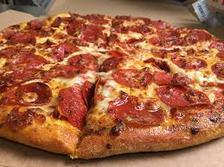
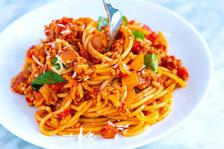
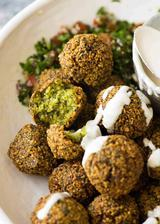
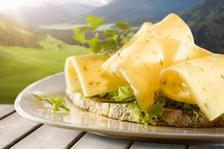
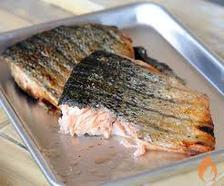
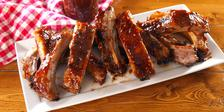
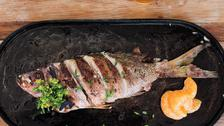
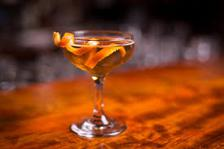
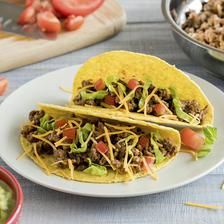
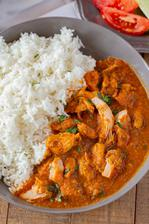
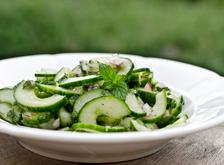
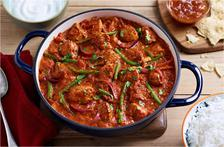
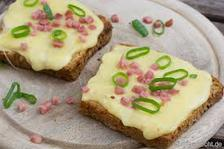
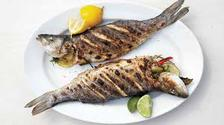
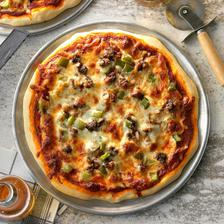
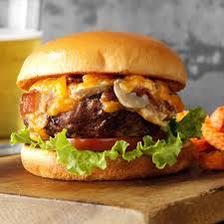
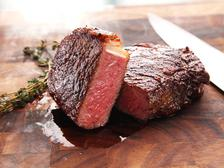

In [84]:
from collections import defaultdict

nearest_cols = defaultdict(list)
num_nearest = 7

examples_df = pd.DataFrame(
    {"image_path": [f"data/examples/{img}" for img in os.listdir("data/examples")]}
)

examples_dataset = ImageDataset(examples_df)
examples_dataloader = torch.utils.data.DataLoader(
    examples_dataset, batch_size=1, shuffle=False, num_workers=1
)

predictions = []
for image in examples_dataloader:
    image = image.to(device)
    with torch.no_grad():
        p = feature_extractor(image)
        predictions.append(p.squeeze())
examples_df["prediction"] = predictions

for p in examples_df.prediction:
    nearest = annoy_index.get_nns_by_vector(p, num_nearest)
    for ii, n in enumerate(nearest):
        nearest_cols[ii].append(df.iloc[n].high_freq_labels)

for key, col in nearest_cols.items():
    examples_df[f"n_{key}"] = col

HTML(
    examples_df.drop(["prediction"], axis=1).to_html(
        formatters={**{"image_path": image_formatter}}, escape=False
    )
)